In [1]:
import numpy as np 
import torch 
import math 
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import time
from fastPLNmodels.VRA import SAGARAD,SAGRAD,SVRGRAD
from tqdm import tqdm 
import seaborn as sns

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
#get the device
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


In [4]:
N_samples = 300
p = 4
d = 2

In [5]:
X = torch.randn(N_samples, d, device = device)+2
true_beta = torch.randn(d,p, device = device)
Y = X@true_beta + torch.randn(N_samples, p, device = device)*0.1
beta_star = (torch.inverse((X.T)@X)@(X.T))@Y

In [6]:
def get_batch(X,Y,batch_size): 
    '''
    get the batches required to do a  minibatch gradient ascent.  

    args : 
            'batch_size' int.  the batch size you want. 

    returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                since the rest of the division is not always 0)
    '''
    #np.random.seed(2)
    n = Y.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    # get the number of batches and the size of the last one. 
    nb_full_batch, last_batch_size  = n//batch_size, n % batch_size  
    for i in range(nb_full_batch): 
        yield   (X[indices[i*batch_size: (i+1)*batch_size]],
                 Y[indices[i*batch_size: (i+1)*batch_size]],
                 indices[i*batch_size: (i+1)*batch_size]
                )
    if last_batch_size != 0 :
        yield   (X[indices[-last_batch_size:]], Y[indices[-last_batch_size:]],
                  indices[-last_batch_size:],
                )
        


In [7]:
def show(res_VR, res_noVR, names = ['VR', 'noVR'], save = False, name_doss = ''):
    abscisse = np.arange(len(res_VR[0]))
    fig, axes = plt.subplots(3,1, figsize = (10,10))
    axes[0].plot(abscisse, res_VR[0], label = names[0] )
    axes[0].plot(abscisse, res_noVR[0], label = names[1] )
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_title('Objective function')
    
    axes[1].plot(abscisse, res_VR[1], label = names[0] )
    axes[1].plot(abscisse, res_noVR[1], label = names[1] )
    axes[1].legend()
    axes[1].set_title('Gradient norm')
    axes[1].set_yscale('log')    
    
    axes[2].plot(abscisse, res_VR[2], label = names[0])
    axes[2].plot(abscisse, res_noVR[2], label = names[1])
    axes[2].set_title(r'$\|\|\beta- \beta^{\star}\|\|$')
    axes[2].legend()
    axes[2].set_yscale('log')
    plt.show()
    #if save:
    #    plt.save_fig
    


In [8]:
def f(x,y_i): 
    return 1/2*torch.norm(x@beta-y_i)**2

def F(beta): 
    return 1/2*torch.mean(torch.norm(Y-X@beta, dim = (1))**2)

def grad_F(beta): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y-X@beta).unsqueeze(1)) , axis = 0)

def batch_grad(beta,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@beta).unsqueeze(1))

def fit(nb_step, choice_optim, lr, batch_size, vr_bool, VR):
    beta = torch.zeros((d,p), requires_grad = True, device = device)
    optim = choice_optim([beta], lr = lr)
    F_beta_list = list()
    diff_true_grad_list = list()
    norm_grad_list = list()
    running_times = list()
    diff_true_param = list()
    t0 = time.time()
    if vr_bool :
        vr = VR([beta], N_samples)
    for i in tqdm(range(nb_step)):
        #if vr_bool :
        #    vr.bias = 1/N_samples
        for x_b,y_b, selected_indices in get_batch(X,Y, batch_size):
            optim.zero_grad()
            batch_grad_beta = batch_grad(beta, x_b, y_b)
            if vr_bool :  
                vr.update_new_grad([batch_grad_beta], selected_indices)
            else :
                beta.grad = torch.mean(batch_grad_beta, axis = 0)
            true_grad = torch.tensor([0])#grad_F(beta)
            diff_true_param.append(torch.norm(beta-beta_star).item())
            norm_grad_list.append(torch.norm(beta.grad).item())
            optim.step()
            F_beta_list.append(F(beta).item())
            running_times.append(time.time()-t0)
        
    return [F_beta_list, norm_grad_list, diff_true_param, running_times, optim]


def phase_1(T, theta, lr, choice_optim, batch_size): 
    beta = torch.zeros((d,p), requires_grad = True, device = device)
    optim = choice_optim([beta], lr = lr)
    Gt_norm = list()
    R_list = list()
    F_beta_list = list()
    diff_true_param = list()
    norm_grad_list = list()
    running_times = list()
    t0 = time.time()
    t = 0
    i = 0 
    stop_condition = False
    while i < int(T*batch_size) and stop_condition == False: 
        for  x_b, y_b, selected_indices in get_batch(X,Y, batch_size):
            optim.zero_grad()
            batch_grad_beta = batch_grad(beta, x_b, y_b)
            beta.grad = torch.mean(batch_grad_beta, axis = 0)
            optim.step()
            
            Gt_norm.append(torch.sum((optim.state_dict()['state'][0]['sum'])).item())
            if t%2 ==0  : 
                R = (Gt_norm[t]-Gt_norm[int(t/2)])/Gt_norm[int(t/2)]
                R_list.append(R)
                if R> theta and t>N_samples: 
                    stop_condition = True
                    print('stopped since R = ', R)
            else: 
                R_list.append(R_list[-1])
            optim.zero_grad()
            diff_true_param.append(torch.norm(beta-beta_star).item())
            norm_grad_list.append(torch.norm(beta.grad).item())
            optim.step()
            F_beta_list.append(F(beta).item())
            running_times.append(time.time()-t0)
            t+=1
        i+=1
    return [F_beta_list, norm_grad_list, diff_true_param, running_times, optim, R_list, Gt_norm]
        

        

In [11]:
T = 200
theta = 1/2
choice_optim = torch.optim.Adagrad
batch_size = 20
lr = 0.1
# %time res_ada = phase_1(T, 0.1,  lr, choice_optim, batch_size)

/home/bastien/anaconda3/envs/torch_env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


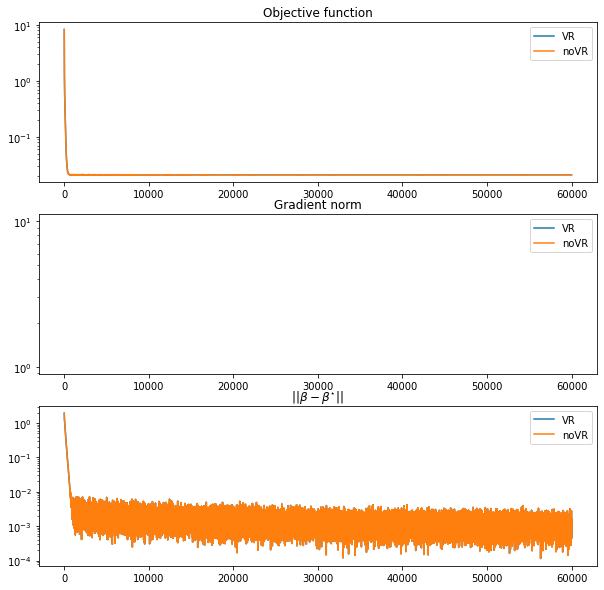

In [161]:
show(res_ada, res_ada)

No handles with labels found to put in legend.


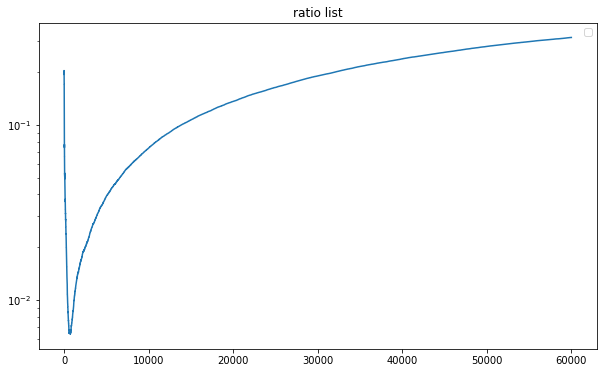

In [164]:
figure(figsize = (10,6))

plt.plot(np.arange(len(res_ada[-4][10:])), res_ada[-2][10:])
plt.yscale('log')
plt.title('ratio list')
plt.legend()

No handles with labels found to put in legend.


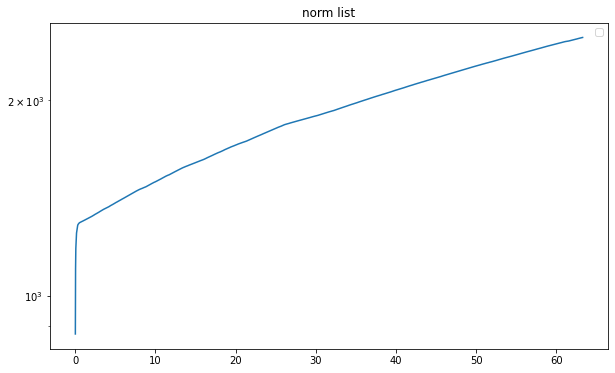

In [163]:
figure(figsize = (10,6))
plt.plot(res_ada[-4][10:], res_ada[-1][10:])
plt.yscale('log')
plt.title('norm list')
plt.legend()

In [40]:
lr = 1
nb_iter = 600
optim = torch.optim.Adagrad
batch_size = 20

In [41]:
res_VR = fit(nb_iter,optim, lr, batch_size, vr_bool = True, VR = SAGARAD)

100%|██████████| 600/600 [00:04<00:00, 142.20it/s]


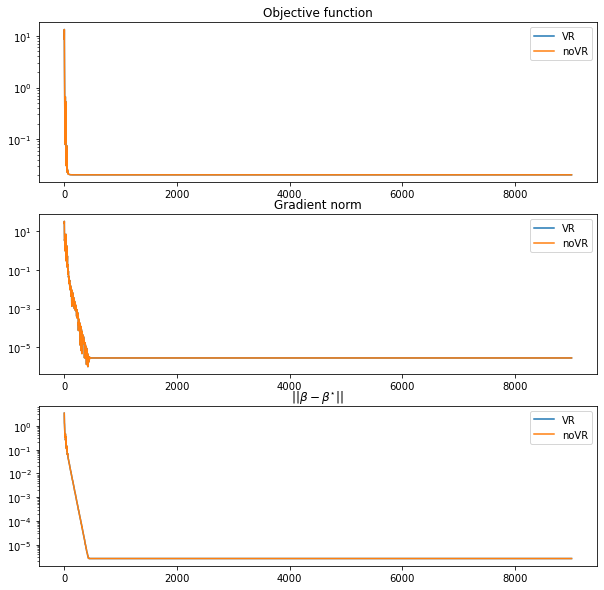

In [42]:
show(res_VR, res_VR)

In [84]:
res_VR[-1].state_dict()

{'state': {0: {'step': 300,
   'sum': tensor([[ 279180.3750,  175359.6875,  241244.1094, 1278797.8750],
           [ 443684.0938,  124266.4609,  165574.3906,  238096.4688]],
          device='cuda:0')}},
 'param_groups': [{'lr': 1,
   'lr_decay': 0,
   'eps': 1e-10,
   'weight_decay': 0,
   'initial_accumulator_value': 0,
   'params': [0]}]}

In [70]:
res_noVR = fit(nb_iter,optim, lr , batch_size, vr_bool = False, VR = SAGRAD)

100%|██████████| 600/600 [00:06<00:00, 88.77it/s]


In [71]:
res_noVR[-1]

Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 1
    lr_decay: 0
    weight_decay: 0
)

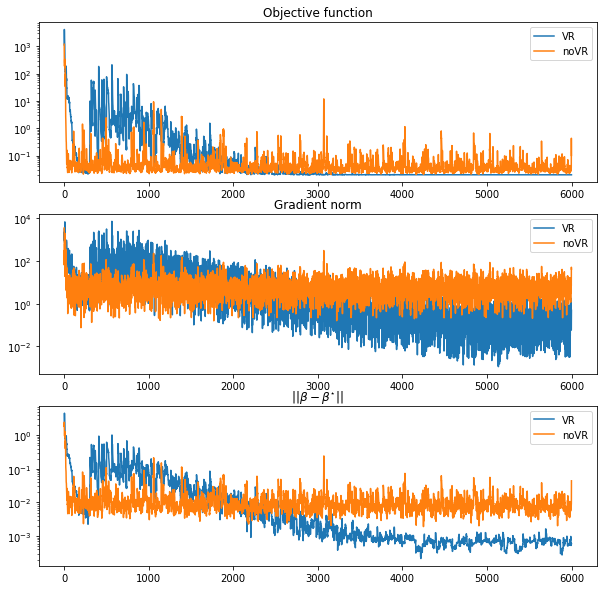

In [57]:
show(res_VR, res_noVR)

100%|██████████| 600/600 [00:05<00:00, 100.87it/s]


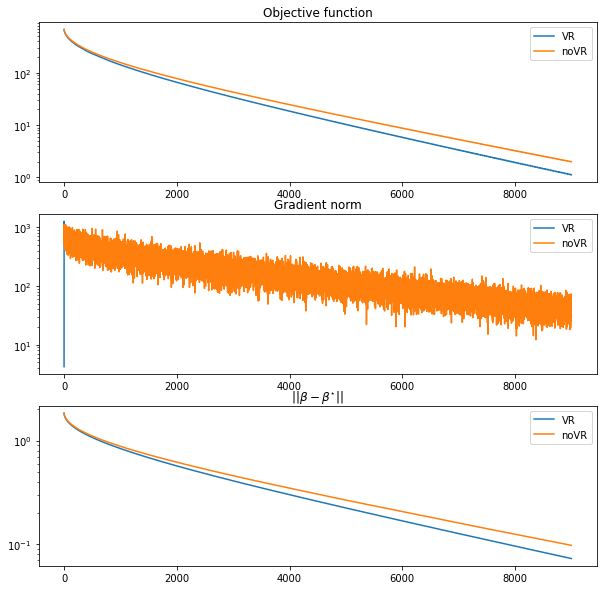

100%|██████████| 600/600 [00:07<00:00, 82.83it/s]


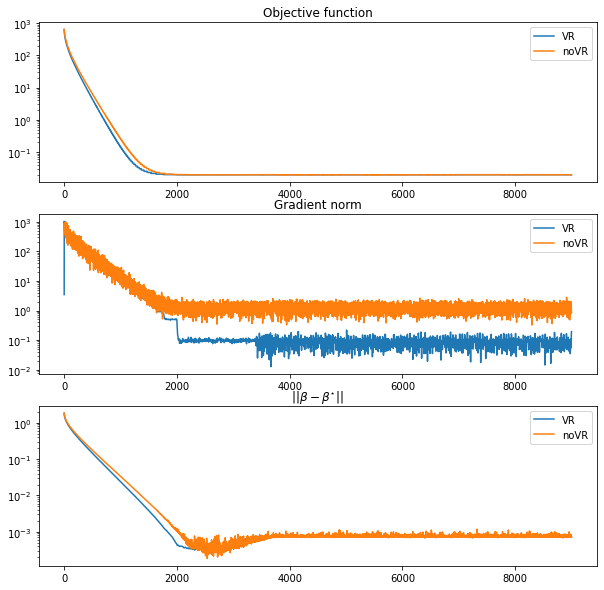

100%|██████████| 600/600 [00:06<00:00, 95.59it/s]


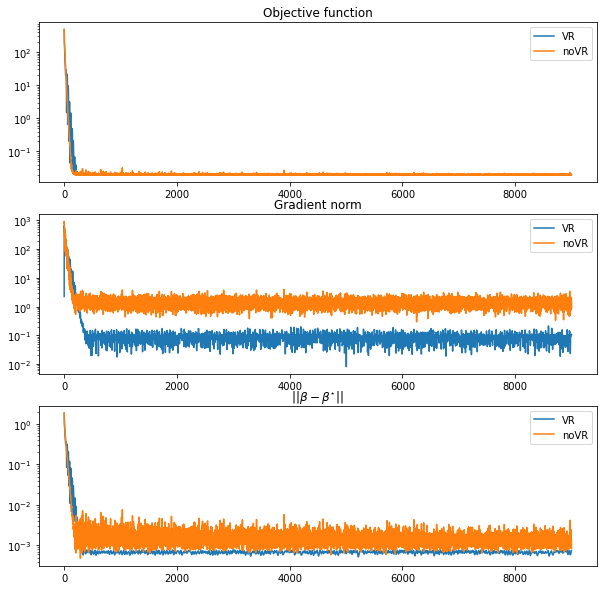

100%|██████████| 600/600 [00:06<00:00, 89.19it/s] 


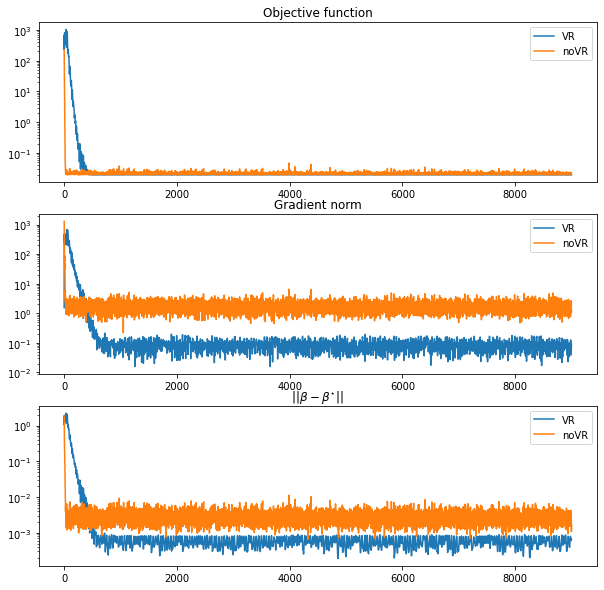

100%|██████████| 600/600 [00:08<00:00, 72.94it/s] 


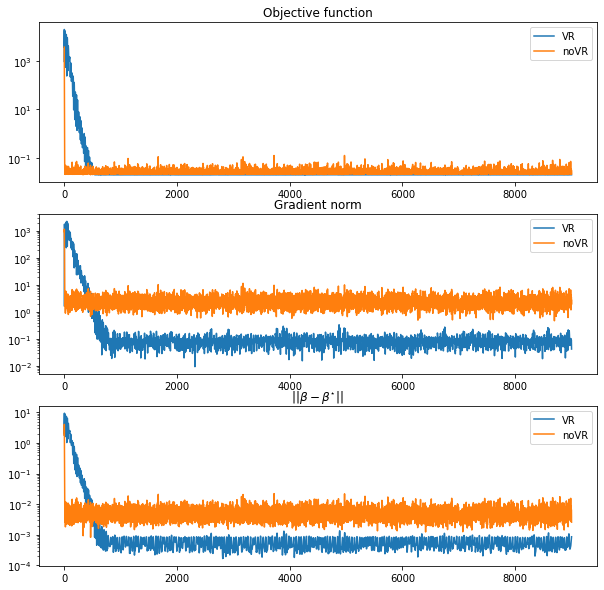

100%|██████████| 600/600 [00:06<00:00, 97.99it/s] 


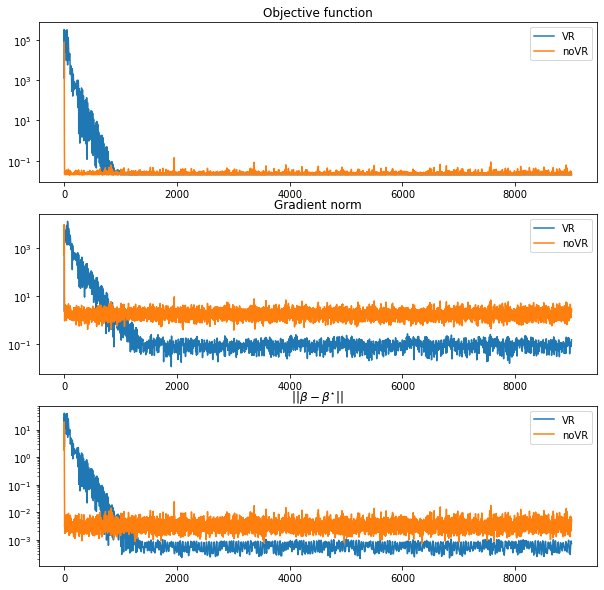

100%|██████████| 600/600 [00:06<00:00, 98.42it/s] 


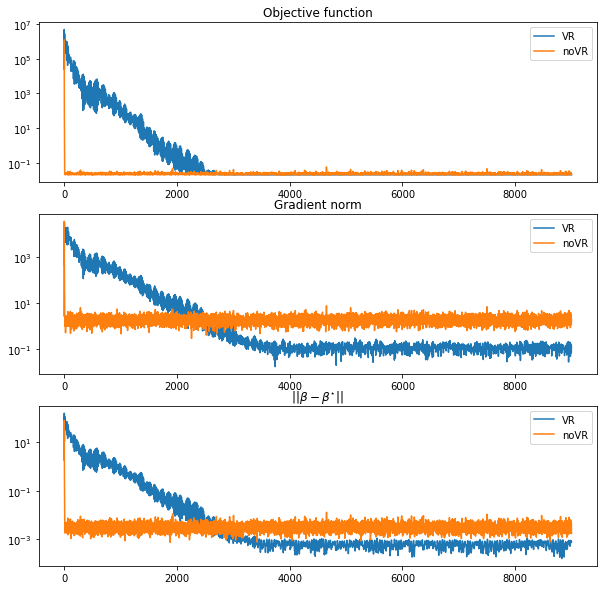

100%|██████████| 600/600 [00:06<00:00, 91.58it/s] 


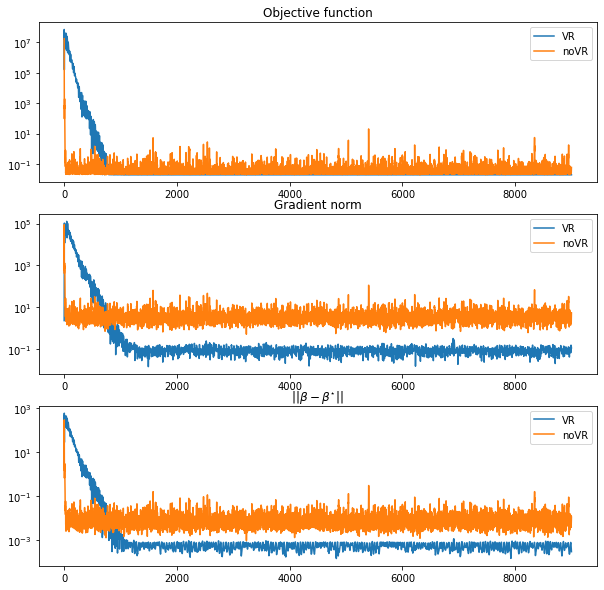

In [65]:
list_precision_VR = []
list_precision_noVR = []
list_res_VR = []
nb_iter = 600
list_res_noVR = []
learning_rates = np.logspace(-2,2, num = 8)
for learning_rate in learning_rates:
    res_VR = fit(nb_iter,optim, learning_rate, batch_size, vr_bool = True, VR = SAGRAD)
    res_noVR = fit(nb_iter,optim, learning_rate, batch_size, vr_bool = False, VR = SAGRAD)
    show(res_VR, res_noVR)
    list_res_VR.append(res_VR)
    list_res_noVR.append(res_noVR)
    list_precision_VR.append(np.mean(res_VR[2][-50:]))
    list_precision_noVR.append(np.mean(res_noVR[2][-50:]))


### Results: abscisse = learning rate, ordonnées = précision de l'estimateur apres x itération. 

## SAGARAD with batch_size 1

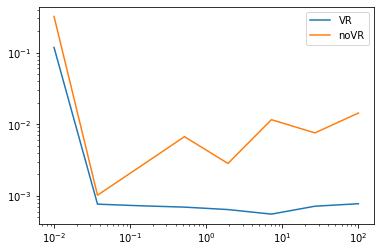

In [61]:
plt.plot(learning_rates, list_precision_VR, label = 'VR')
plt.plot(learning_rates, list_precision_noVR, label = 'noVR')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## SAGARAD with batch_size 20

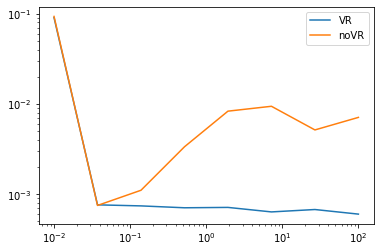

In [34]:
plt.plot(learning_rates, list_precision_VR, label = 'VR')
plt.plot(learning_rates, list_precision_noVR, label = 'noVR')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## SAGRAD with batch_size 1

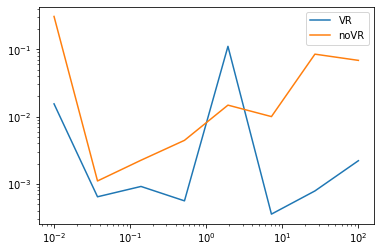

In [63]:
plt.plot(learning_rates, list_precision_VR, label = 'VR')
plt.plot(learning_rates, list_precision_noVR, label = 'noVR')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## SAGRAd with batch_size 20

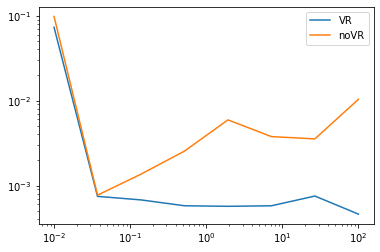

In [66]:
plt.plot(learning_rates, list_precision_VR, label = 'VR')
plt.plot(learning_rates, list_precision_noVR, label = 'noVR')
plt.legend()
plt.yscale('log')
plt.xscale('log')